<a href="https://colab.research.google.com/github/emiliopugnaloni/Crimenes-Caba/blob/main/1%20-%20Tecnicas%20descriptivas%20en%20ST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Libraries**

In [ ]:
options(repos = "https://cloud.r-project.org/")

install.packages('dplyr')
install.packages('tidyr')
install.packages('ggplot2')
install.packages('tibble')
install.packages('aTSA')
install.packages('zoo')
install.packages('tseries')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’




In [ ]:
install.packages('fpp')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fracdiff’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’, ‘forecast’, ‘fma’, ‘expsmooth’, ‘lmtest’




In [ ]:
library(readxl)
library(dplyr)
library(tidyr)
library(zoo)
library(ggplot2)
library(tibble)
library(aTSA)
library (fpp)


Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:aTSA’:

    forecast


Loading required package: fma

Loading required package: expsmooth

Loading required package: lmtest

Loading required package: tseries


Attaching package: ‘tseries’


The following objects are masked from ‘package:aTSA’:

    adf.test, kpss.test, pp.test




## **Imports**

In [ ]:
# Imports
data_robo_hurto <- read.csv('datos_hurto_robo.csv')

data_robo_hurto_agrupado =  data_robo_hurto %>%
  filter(tipo %in% c("Hurto", "Robo")) %>%
  group_by(fecha, No_Laborable) %>%
  summarise(count = n(), .groups = 'drop') %>%
  filter(fecha >= as.POSIXct("2020-12-31")) %>%
  mutate(ma7 = rollmean(count, k = 7, fill = NA, align = "right"))  %>%
  mutate(ma30 = rollmean(count, k = 30, fill = NA, align = "right"))


In [ ]:
print("Cantidad de datos", length(data_robo_hurto_agrupado$fecha))

[1] 1095


## **Dominio de la Frecuencia**

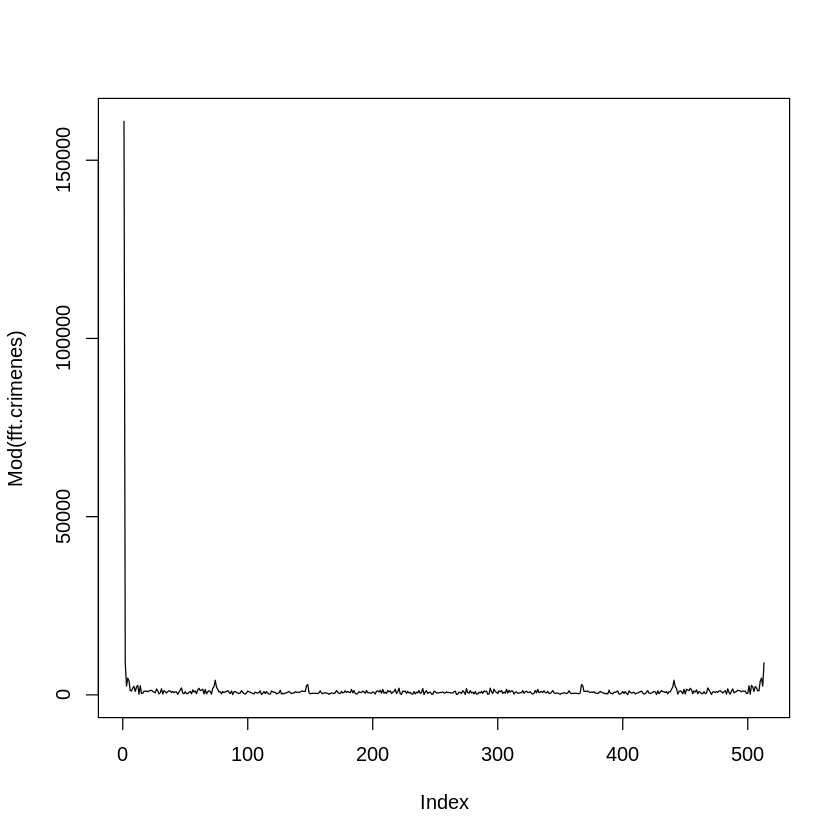

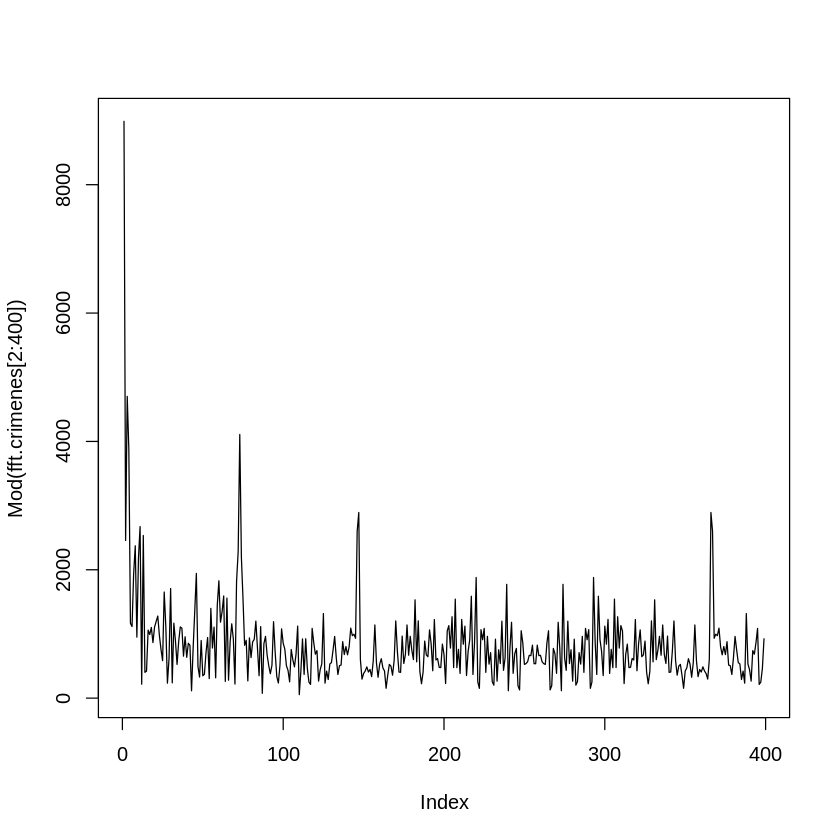

In [ ]:

N_start <- 366  # emepezamos desde 2022
N <- 2^9
op <- par(mfrow = c(1, 1))

fft.crimenes = fft(data_robo_hurto_agrupado$count[N_start: (N_start+N)])
plot(Mod(fft.crimenes),type='l')
plot(Mod(fft.crimenes[2:400]),type='l')

## **Filtros MA**

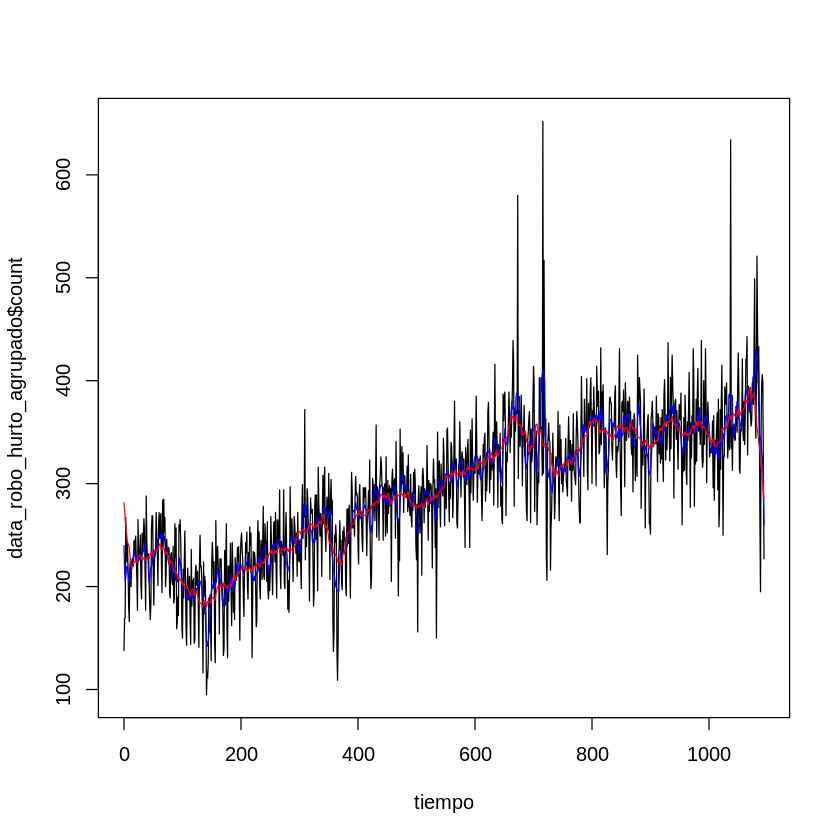

In [ ]:
N <-length(data_robo_hurto_agrupado$fecha)
tiempo <- 0:(N-1)
x <- data_robo_hurto_agrupado$count

plot(tiempo, data_robo_hurto_agrupado$count , type='l')
crimenes.MA7 = stats::filter( x ,rep(1/7,7), circular =TRUE)
lines (tiempo, crimenes.MA7,col='blue')
crimenes.MA30 = stats::filter( x ,rep(1/30,30), circular =TRUE)
lines (tiempo, crimenes.MA30,col='red')


## **Descomposicion de la Serie con Filtro MA**


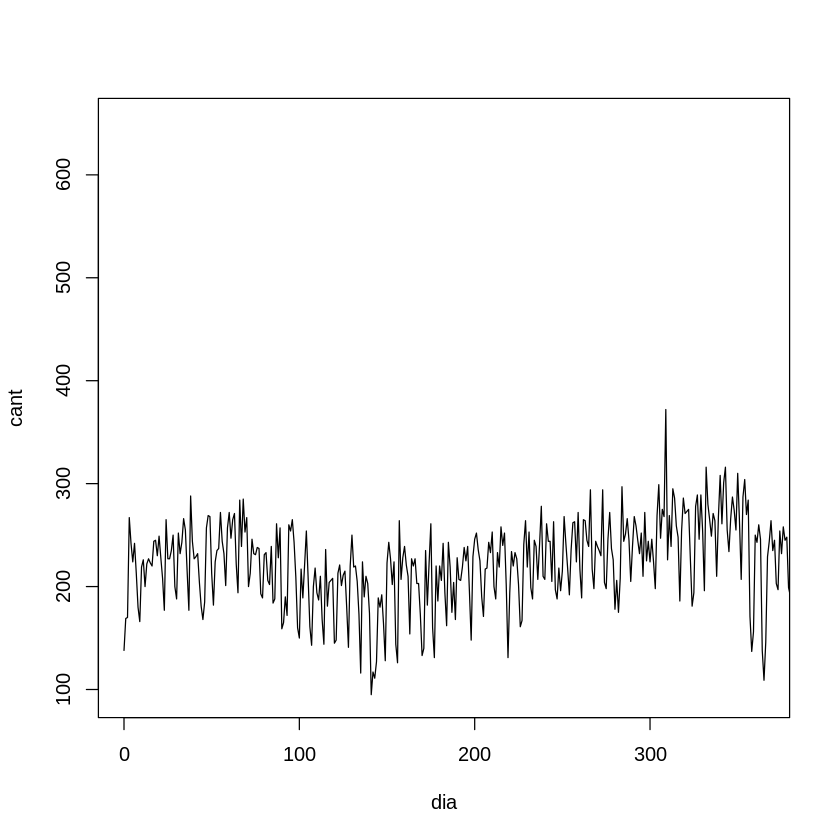

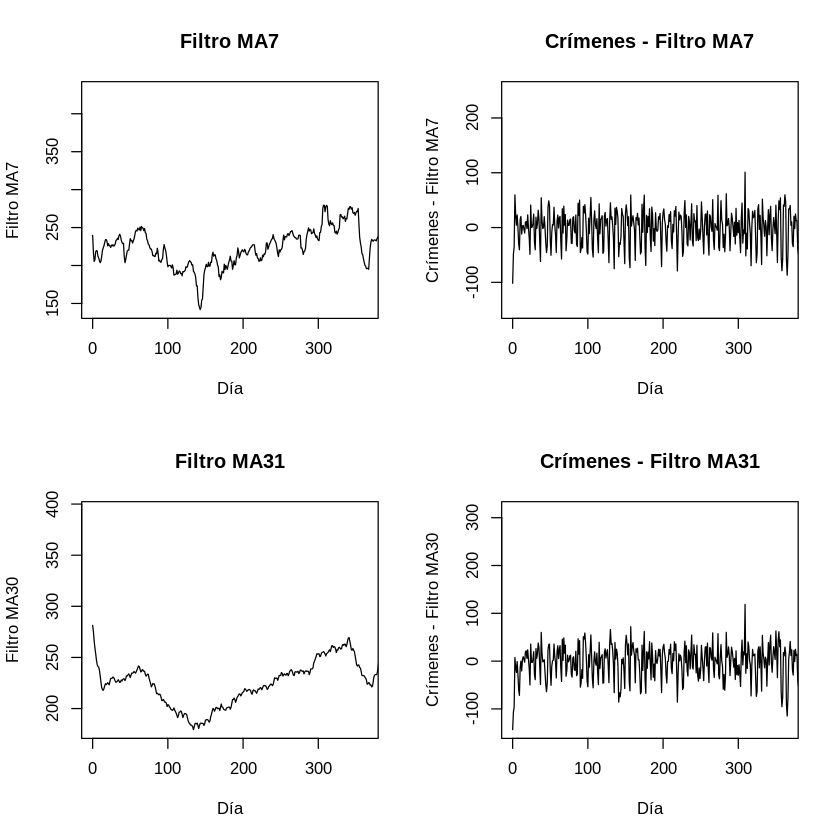

In [ ]:
# Serie Original
plot(tiempo,x,type='l' , xlim=c(0,365),xlab='dia' , ylab='cant')

difMA7 <- x - crimenes.MA7
difMA30 <- x - crimenes.MA30

op <- par(mfrow = c(2, 2))

plot(tiempo, crimenes.MA7, type='l', xlim=c(0, 365), xlab='Día', ylab='Filtro MA7',
     main = "Filtro MA7")
plot(tiempo, difMA7, type='l', xlim=c(0, 365), xlab='Día', ylab='Crímenes - Filtro MA7',
     main = "Crímenes - Filtro MA7")
plot(tiempo, crimenes.MA30, type='l', xlim=c(0, 365), xlab='Día', ylab='Filtro MA30',
     main = "Filtro MA31")
plot(tiempo, difMA30, type='l', xlim=c(0, 365), xlab='Día', ylab='Crímenes - Filtro MA30',
     main = "Crímenes - Filtro MA31")

par(op)


Vemos ahora como es en el dominio de la freq


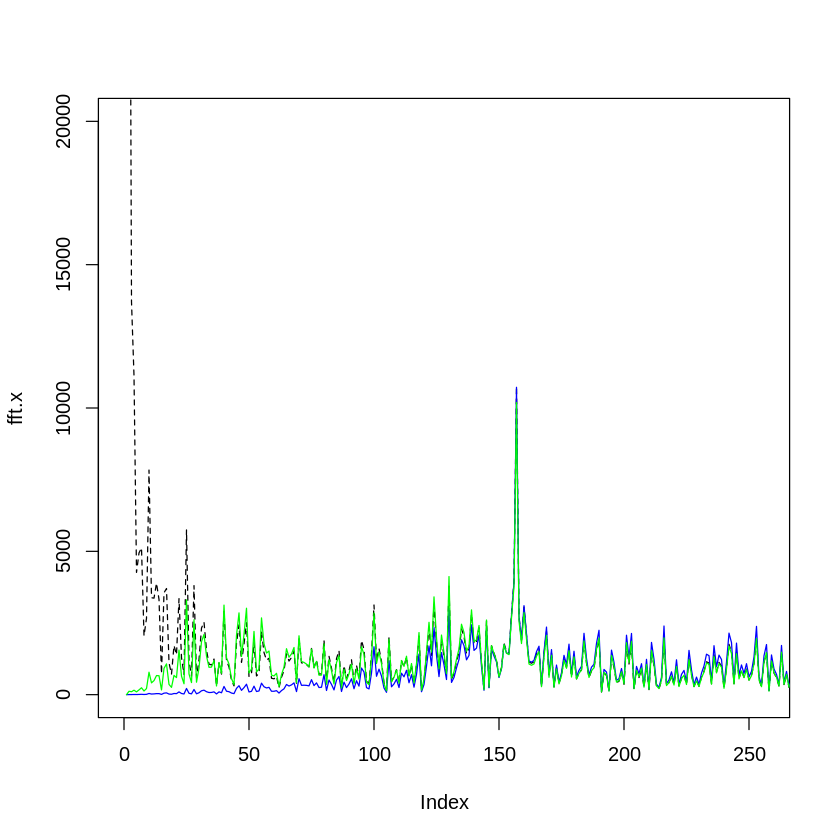

In [ ]:
fft.x = Mod(fft(x))
fft.outMA7 = Mod(fft(crimenes.MA7))
fft.difMA7 = Mod(fft(difMA7))
fft.outMA21 = Mod(fft(crimenes.MA30))
fft.difMA21 = Mod(fft(difMA30))

op <- par(mfrow = c(1, 1))

plot( fft.x , type='l' , col='black', ylim=c(0,20000), xlim=c(0,256), lty =2)
#lines ( fft.outMA7,col='black')
lines (fft.difMA7 ,col='blue') # es un filtro pasa bajo (saca altas freq)
#lines (fft.outMA21 ,col='red')
lines (fft.difMA21 ,col='green') # es un filtro pasa bajo tambien (aunque menos que el MA7)


## **Autocorrelacion**

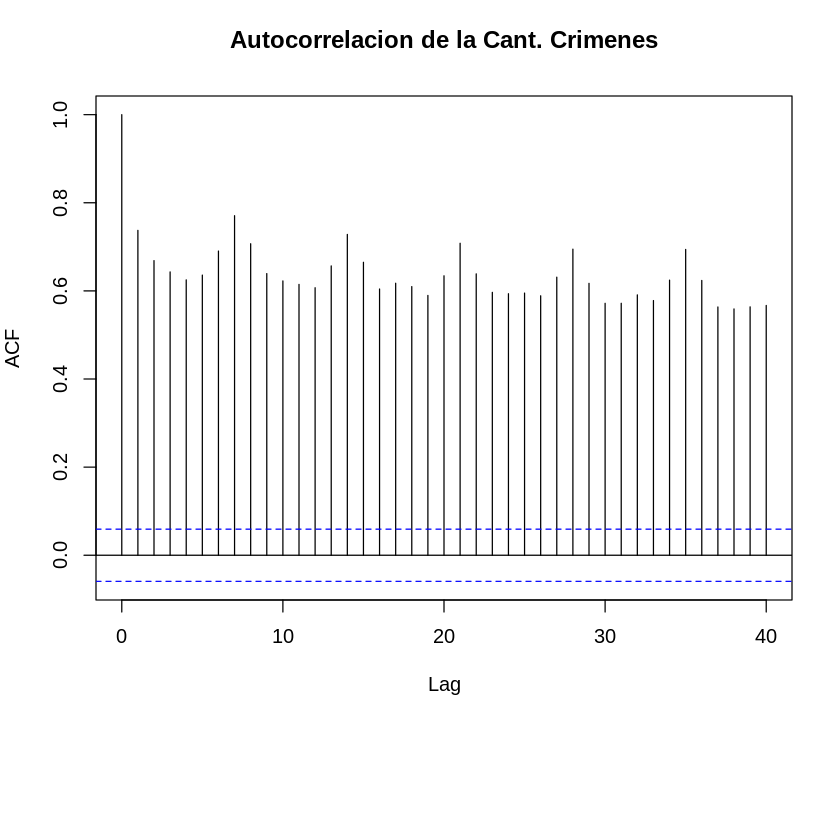

In [ ]:
par(mfrow = c(1, 1), mar = c(10, 4, 4, 2)) # Set the margins and layout
acf(data_robo_hurto_agrupado$count, lag.max = 40, main = "Autocorrelacion de la Cant. Crimenes")


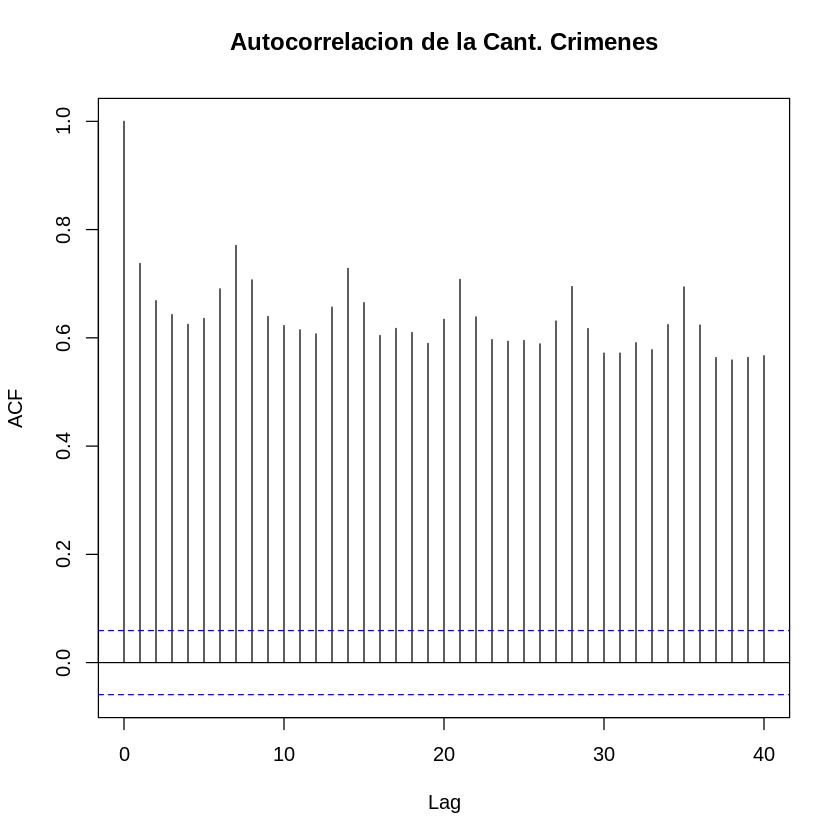

In [ ]:
acf(data_robo_hurto_agrupado$count, lag.max = 40, main = "Autocorrelacion de la Cant. Crimenes")

Hay autocorrelacion maima en 0. Y despues es alta a los 7 dias y al 2do. Cada 7 dias se repite la autocorrelacion


## **Pruebas de Estacionariedad**

In [ ]:
aTSA::adf.test(data_robo_hurto_agrupado$count)
# El test de DF de esta libreria es mas completa.
# 1) Sin considerar Drift ni trend, vemos que no es estacionaria. Los p.values no son todos <0.1
# 2) Sacando la drift (con o sin trend) nos da que es estacionaria

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -2.761  0.0100
[2,]   1 -1.843  0.0663
[3,]   2 -1.369  0.1897
[4,]   3 -1.126  0.2764
[5,]   4 -0.855  0.3731
[6,]   5 -0.505  0.4984
[7,]   6 -0.144  0.6024
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -12.88   0.010
[2,]   1  -9.10   0.010
[3,]   2  -7.23   0.010
[4,]   3  -6.05   0.010
[5,]   4  -5.00   0.010
[6,]   5  -3.76   0.010
[7,]   6  -2.55   0.107
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -23.28    0.01
[2,]   1 -17.93    0.01
[3,]   2 -15.22    0.01
[4,]   3 -13.71    0.01
[5,]   4 -11.87    0.01
[6,]   5  -9.06    0.01
[7,]   6  -5.87    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


In [ ]:
tseries::adf.test(data_robo_hurto_agrupado$count)
# Este paquete (que mira el test de DF con drift, y mirando las 10 autocorrelaciones mas cercnas)

Warning message in tseries::adf.test(data_robo_hurto_agrupado$count):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data_robo_hurto_agrupado$count
Dickey-Fuller = -5.7803, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary


In [ ]:
tseries::kpss.test(data_robo_hurto_agrupado$count)
# Este test tiene como Ho) La serie es estacionaria. Aca nos confirma que no es estacionaria, porque se rechaza la hipotesis

Warning message in tseries::kpss.test(data_robo_hurto_agrupado$count):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  data_robo_hurto_agrupado$count
KPSS Level = 12.173, Truncation lag parameter = 7, p-value = 0.01


## **Descomposicion de Serie**


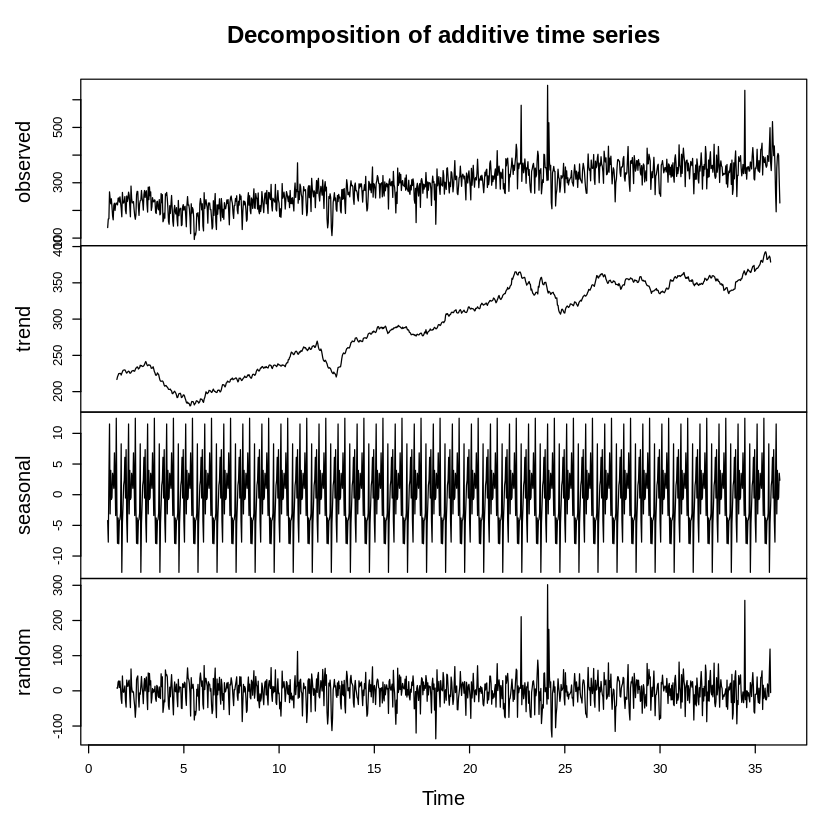

In [ ]:
# MENSUAL

ts_data <- ts(data_robo_hurto_agrupado$count, frequency = 31, start = 1)
fit.decomp <- decompose(ts_data, type = 'additive')
plot(fit.decomp)

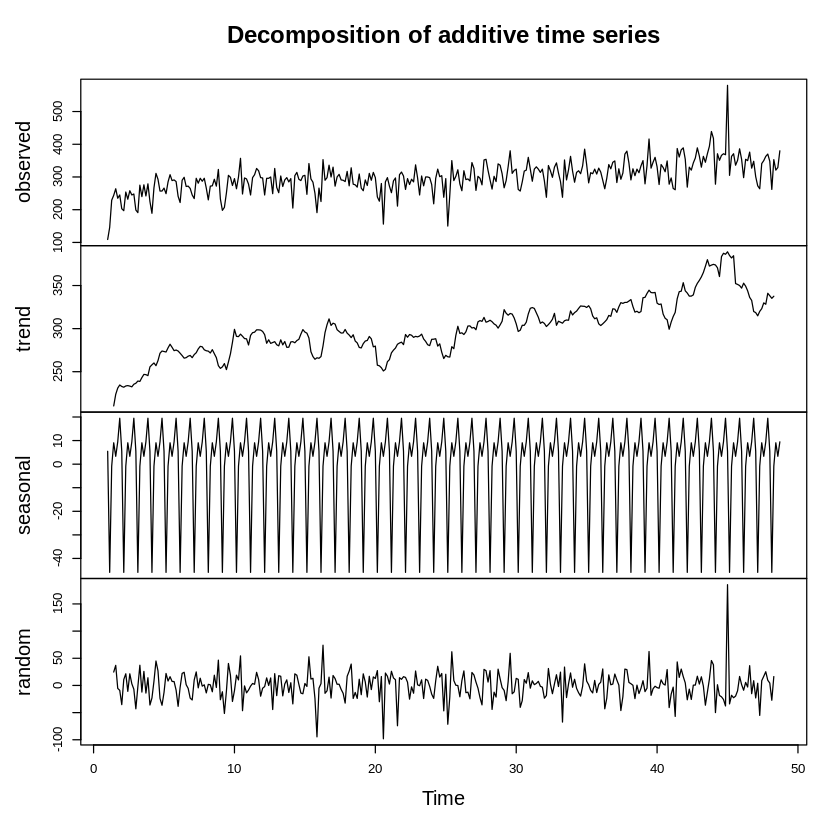

In [ ]:
# Semanal

ts_data <- ts(data_robo_hurto_agrupado$count, frequency = 7, start = 1)
ts_data <- ts(data_robo_hurto_agrupado[366:700,]$count, frequency = 7, start = 1)

fit.decomp <- decompose(ts_data, type = 'additive')
plot(fit.decomp)

# Decompose the time series
fit.decomp <- decompose(ts_data, type = 'additive')



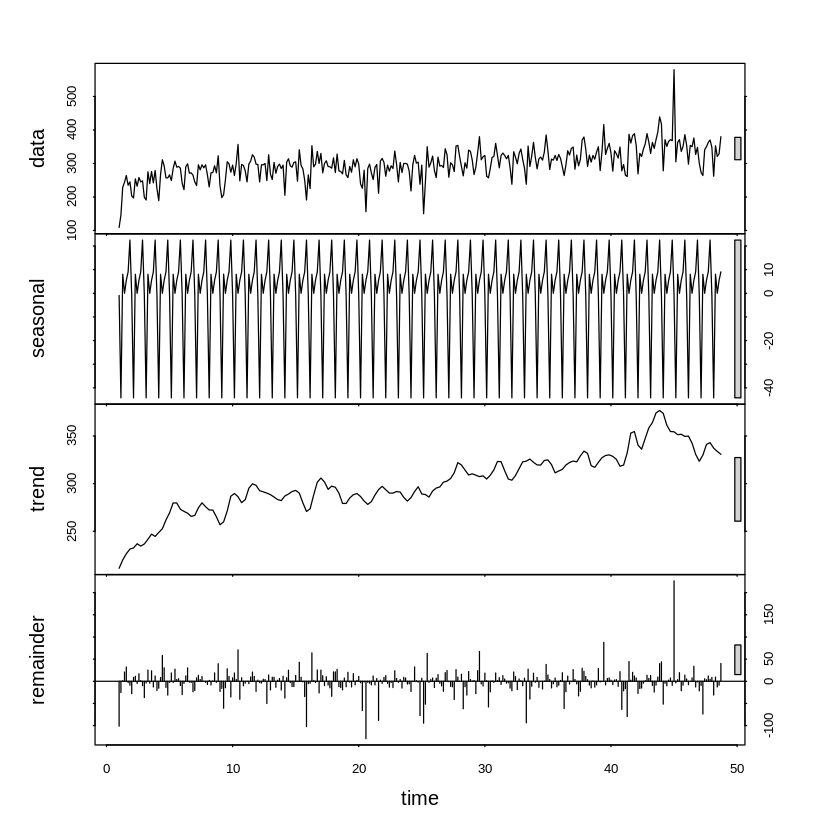

In [ ]:
ts_data <- ts(data_robo_hurto_agrupado[366:700,]$count, frequency = 7, start = 1)
fit.stl <- stl(ts_data, s.window = "periodic", robust=TRUE)
plot(fit.stl)